*Contenuti*
===

- [Resampling](#Resampling)
    - [Esercizio 2.1](#Esercizio-2.1)
- [Rolling windows](#Rolling-windows)
    - [Esercizio 2.2](#Esercizio-2.2)
- [Analisi dei trend di una serie temporale](#Analisi-dei-trend-di-una-serie-temporale)
    - [Esercizio 2.3](#Esercizio-2.3)
    - [Esempi generali di trend](#Esempi-generali-di-trend)
- [Decomposizione](#Decomposizione)
    - [Modello additivo](#Modello-additivo)
    - [*seasonal_decompose*](#seasonal_decompose)
- [Forecast](#Forecast)
    - [Facebook Prophet](#Facebook-Prophet)
    - [Esercizio 2.4](#Esercizio-2.4)
- [Spunti di approfondimento](#Spunti-di-approfondimento)

Nella prima lezione abbiamo visto alcuni esempi di manipolazione e visualizzazione di dati temporali con Pandas, Matplotlib e Seaborn. Abbiamo utilizzato questi strumenti per analizzare la stagionalità di una serie temporale.

Ripartiamo da qui.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
df = pd.read_csv('../data/OPSD_Germany_all.csv',
                 parse_dates=True,
                 index_col='Date')

df['Weekday'] = df.index.day_name()

df.head()

,Consumption,Wind,Solar,Weekday
Date,,,,
2006-01-01,1069.184,NaN,NaN,Sunday
2006-01-02,1380.521,NaN,NaN,Monday
2006-01-03,1442.533,NaN,NaN,Tuesday
2006-01-04,1457.217,NaN,NaN,Wednesday
2006-01-05,1477.131,NaN,NaN,Thursday


Resampling
===
Quando si campiona una serie temporale a una frequenza più bassa di quella originale stiamo facendo *downsampling*. Per questa operazione ci serve una funzione di aggregazione.

Viceversa, aumentare la frequenza di una serie temporale si chiama *upsampling*. Di cosa abbiamo bisogno in questo caso?


Il downsampling è un altro strumento valido per analizzare la stagionalità di una serie temporale. Supponiamo di voler calcolare il consumo medio settimanale del 2013.

In [4]:
df[['Consumption', 'Weekday']].loc['2013'].head(15)

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday


In [5]:
df[['Consumption', 'Weekday']].loc['2013'][:6]

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday


In [6]:
df['Consumption'].loc['2013'][:6].mean()

1101.5313333333331

In [7]:
df[['Consumption', 'Weekday']].loc['2013'][6:13]

,Consumption,Weekday
Date,,
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday
2013-01-10,1388.447,Thursday
2013-01-11,1390.838,Friday
2013-01-12,1192.418,Saturday
2013-01-13,1112.380,Sunday


In [8]:
df['Consumption'].loc['2013'][6:13].mean()

1322.0502857142856

La funzione *resample* realizza quanto sopra in modo compatto.

In [9]:
df['Consumption'].loc['2013'].resample('W')

Pandas prevede scorciatoie (*alias*) per alcune frequenze di ricampionamento (*offset*). Qui l'elenco completo: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases.

Da sola, la funzione resample non basta: ci serve una funzione di aggregazione.

In [10]:
df['Consumption'].loc['2013'].resample('W').mean().head(5)

Date
2013-01-06    1101.531333
2013-01-13    1322.050286
2013-01-20    1388.535857
2013-01-27    1402.458000
2013-02-03    1319.079429
Freq: W-SUN, Name: Consumption, dtype: float64

Tra gli argomenti della funzione resample, *label* permette di scegliere se assegnare al nuovo indice l'estremo sinistro o destro della finestra.

In [11]:
df['Consumption'].loc['2013'].resample('W', label='left').mean().head(5)

Date
2012-12-30    1101.531333
2013-01-06    1322.050286
2013-01-13    1388.535857
2013-01-20    1402.458000
2013-01-27    1319.079429
Freq: W-SUN, Name: Consumption, dtype: float64

Per convenzione, l'estremo sinistro è escluso, il destro incluso. Si può alterare questo comportamento con l'argomento *closed*.

Costruiamo un nuovo dataframe in modo da poterlo plottare comodamente insieme al precedente.

In [12]:
df_consumption_2013_weekly = df['Consumption'].loc['2013'].resample('W').mean()

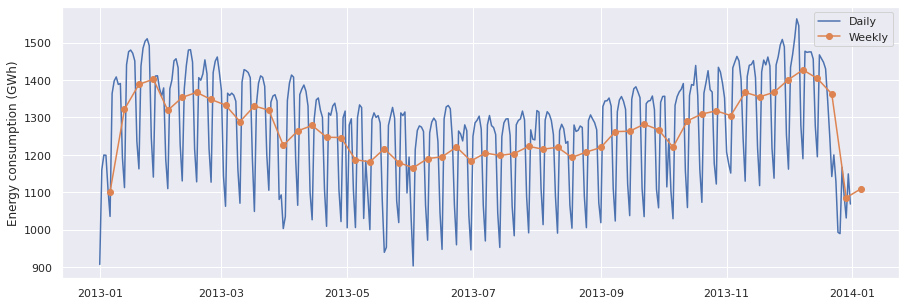

In [13]:
plt.figure(figsize=(15,5))

plt.plot(df['Consumption'].loc['2013'], label='Daily')

plt.plot(df_consumption_2013_weekly,
         marker='o',
         label='Weekly')

plt.ylabel('Energy consumption (GWh)')
plt.legend()

Che effetto abbiamo ottenuto ricampionando con una finestra temporale settimanale?

Esercizio 2.1
---
Confrontare in un unico plot l'andamento mensile di
- consumo di energia elettrica
- produzione di energia rinnovabile (solare, eolica e somma delle due).

Rappresentare l'andamento annuale del rapporto tra
- produzione di energia rinnovabile
- consumo di energia elettrica.

Rolling windows
===
Vediamo adesso un altro strumento di manipolazione di Pandas. Come resample, anche *rolling* prevede un raggruppamento con relativa funzione di aggregazione.

Immaginiamo di voler analizzare i valori di consumo all'interno di una finestra temporale di 3 giorni.

In [14]:
df['Consumption']

Date
2006-01-01    1069.18400
2006-01-02    1380.52100
2006-01-03    1442.53300
2006-01-04    1457.21700
2006-01-05    1477.13100
                 ...    
2017-12-27    1263.94091
2017-12-28    1299.86398
2017-12-29    1295.08753
2017-12-30    1215.44897
2017-12-31    1107.11488
Name: Consumption, Length: 4383, dtype: float64

Facciamo scorrere la finestra da sinistra: ai primi 2 step questa conterrà rispettivamente solo 1 e 2 valori.

In [15]:
df['Consumption'][:1]

Date
2006-01-01    1069.184
Name: Consumption, dtype: float64

In [16]:
df['Consumption'][:2]

Date
2006-01-01    1069.184
2006-01-02    1380.521
Name: Consumption, dtype: float64

A questo punto la finestra si sovrappone ai primi tre valori di consumo.

In [17]:
df['Consumption'][:3]

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
Name: Consumption, dtype: float64

Il processo itera facendo scorrere sequenzialmente la finestra verso destra, una posizione alla volta.

In [18]:
df['Consumption'][1:4]

Date
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
Name: Consumption, dtype: float64

In [19]:
df['Consumption'][2:5]

Date
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

Supponiamo adesso di voler aggregare, ad ogni step, i dati all'interno della finestra. Per esempio, sommandoli.

In [20]:
df['Consumption'][:1].sum()

1069.1840000000002

In [21]:
df['Consumption'][:2].sum()

2449.705000000001

In [22]:
df['Consumption'][:3].sum()

3892.2380000000007

In [23]:
df['Consumption'][1:4].sum()

4280.271000000001

In [24]:
df['Consumption'][2:5].sum()

4376.881

Una volta scelta l'ampiezza della finestra e la funzione di aggregazione, rolling permette di eseguire questa operazione in modo compatto.

In [25]:
df['Consumption'].rolling('3D').sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Si può specificare l'ampiezza della finestra anche con il numero di record che questa deve includere.

In [26]:
df['Consumption'].rolling(3).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

In questo modo però la finestra scarta di default tutti i gruppi dove mancano alcuni valori. Questo comportamento si può modificare con gli argomenti opzionali della funzione.

In [27]:
df['Consumption'].rolling(3, min_periods=1).sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Vediamo altri esempi di utilizzo.

In [28]:
df['Consumption'].rolling(3, center=True).sum()

Date
2006-01-01           NaN
2006-01-02    3892.23800
2006-01-03    4280.27100
2006-01-04    4376.88100
2006-01-05    4337.77500
                 ...    
2017-12-27    3693.92172
2017-12-28    3858.89242
2017-12-29    3810.40048
2017-12-30    3617.65138
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

In [29]:
df['Consumption'][:7].sum()

9530.300000000001

In [30]:
df['Consumption'].rolling(7, center=True).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03           NaN
2006-01-04    9530.30000
2006-01-05    9669.10100
                 ...    
2017-12-27    8457.49890
2017-12-28    8422.85648
2017-12-29           NaN
2017-12-30           NaN
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

Adesso vediamo il risultato grafico prodotto da rolling. Per comodità, settiamo una volta per tutte la proprietà *figsize* di Matplotlib.

In [31]:
plt.rcParams['figure.figsize'] = (15,5)

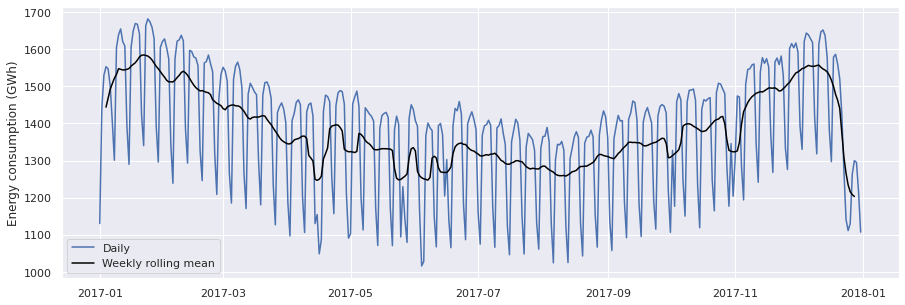

In [32]:
plt.plot(df['Consumption'].loc['2017'],
         label='Daily')

plt.plot(df['Consumption'].loc['2017'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.ylabel('Energy consumption (GWh)')
plt.legend()

Abbiamo calcolato e rappresentato la *rolling mean* settimanale dei dati di consumo elettrico del 2017.

Esercizio 2.2
---
Abbiamo visto che resample e rolling partono da un'idea comune. Che differenza c'è tra i risultati che producono?


Rappresentare i valori medi settimanali di produzione di energia solare nel periodo 01-07/2017, utilizzando le funzioni resample e rolling. Confrontare i due risultati prodotti.

---

**Recap**: sia il downsampling che l'applicazione di una rolling window producono un effetto di smoothing sulla serie temporale. In particolare, vengono cancellate le variazioni che avvengono a una frequenza minore o uguale a quella della finestra temporale utilizzata.

Eliminando le variazioni stagionali è possibile analizzare un' altra componente fondamentale di una serie temporale: il **trend**.

Analisi dei trend di una serie temporale
---

Partiamo dalla visualizzazione dei dati di consumo a frequenza giornaliera.

Text(0.5, 1.0, 'Electrical energy consumption (GWh)')

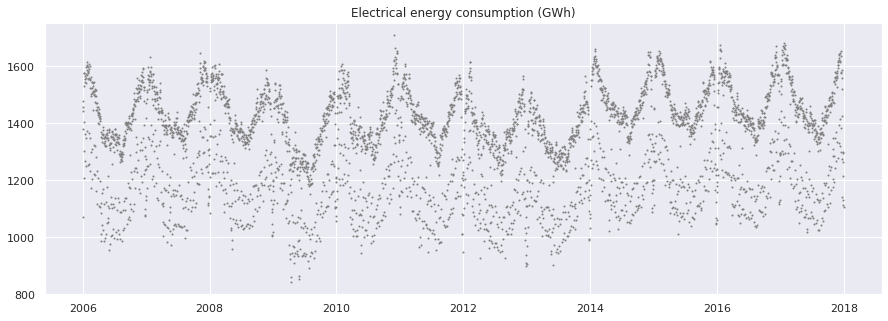

In [33]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         color='gray')
plt.title('Electrical energy consumption (GWh)')

Come abbiamo visto nella scorsa lezione, il consumo tedesco di energia elettrica presenta stagionalità annuale e settimanale.

Aggiungiamo al grafico la media mobile settimanale dei consumi.

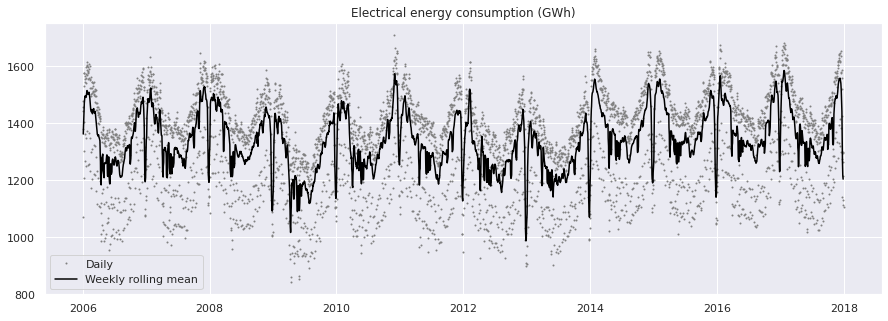

In [34]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         label='Daily',
         color='gray')

plt.plot(df['Consumption'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.title('Electrical energy consumption (GWh)')
plt.legend()

Come ci aspettiamo, la media mobile settimanale cancella la relativa stagionalità. Viene così messa in evidenza la stagionalità annuale e possiamo apprezzare:
- l'andamento oscillatorio dovuto all'utilizzo del riscaldamento e dell'illuminazione elettrica
- i picchi negativi invernali in corrispondenza del periodo di vacanza.

Continuiamo l'analisi aggiungendo al grafico la media mobile annuale.

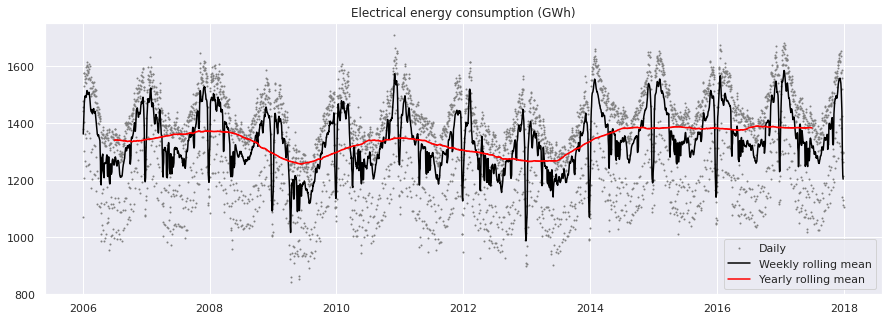

In [35]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         label='Daily',
         color='gray')

plt.plot(df['Consumption'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.plot(df['Consumption'].rolling(365, center=True).mean(),
         label='Yearly rolling mean',
         color='red')

plt.title('Electrical energy consumption (GWh)')
plt.legend()

Una volta eliminata la stagionalità di una serie, quello che rimane è (più o meno, vediamo a breve) il suo **trend** di lungo periodo.

Esercizio 2.3
---

Analizzare il trend della produzione di energia solare a partire dal 2012.

Confrontare, a partire dal 2006, i trend di
- produzione di energia solare
- produzione di energia eolica
- produzione totale di energia rinnovabile.

Esempi generali di trend
---
Prima di proseguire, facciamo un brevissimo confronto tra alcuni tipi di trend. Generiamoli sinteticamente con NumPy.

In [36]:
import numpy as np

In [37]:
plt.rcParams['figure.figsize'] = (15,3)

Un trend lineare è assimilabile a una linea retta: il tasso di crescita non cambia nel tempo.

In [38]:
linear_trend = np.array([5*t for t in range(50)])
linear_trend

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245])

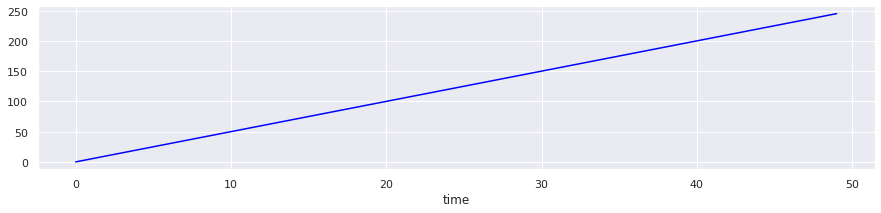

In [39]:
plt.xlabel('time')
plt.plot(linear_trend, color='blue')

Un trend quadratico, più in generale uno polinomiale, è assimilabile ad una curva. Il tasso di crescita varia nel tempo.

In [40]:
quadratic_trend = np.array([t**2 for t in range(50)])
quadratic_trend

array([   0,    1,    4,    9,   16,   25,   36,   49,   64,   81,  100,
        121,  144,  169,  196,  225,  256,  289,  324,  361,  400,  441,
        484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024,
       1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849,
       1936, 2025, 2116, 2209, 2304, 2401])

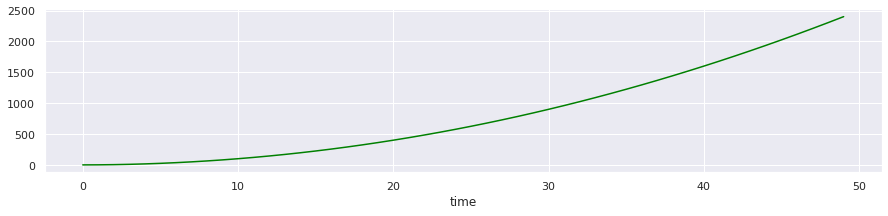

In [41]:
plt.xlabel('time')
plt.plot(quadratic_trend, color='green')

Anche un trend esponenziale è una curva, ma il suo tasso di crescita sale in modo molto più rapido: il tempo è all'esponente!

In [42]:
exponential_trend = np.array([2**t for t in range(50)])
exponential_trend

array([              1,               2,               4,               8,
                    16,              32,              64,             128,
                   256,             512,            1024,            2048,
                  4096,            8192,           16384,           32768,
                 65536,          131072,          262144,          524288,
               1048576,         2097152,         4194304,         8388608,
              16777216,        33554432,        67108864,       134217728,
             268435456,       536870912,      1073741824,      2147483648,
            4294967296,      8589934592,     17179869184,     34359738368,
           68719476736,    137438953472,    274877906944,    549755813888,
         1099511627776,   2199023255552,   4398046511104,   8796093022208,
        17592186044416,  35184372088832,  70368744177664, 140737488355328,
       281474976710656, 562949953421312])

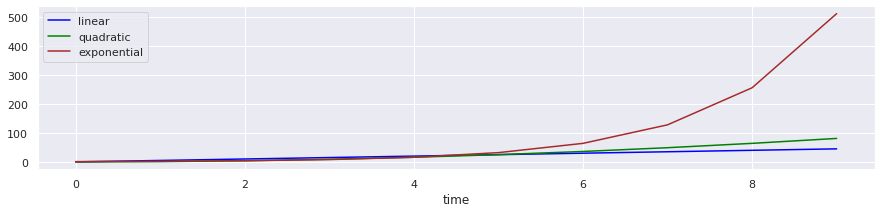

In [43]:
plt.plot(linear_trend[:10], label='linear', color='blue')
plt.plot(quadratic_trend[:10], label='quadratic', color='green')
plt.plot(exponential_trend[:10], label='exponential', color='brown')

plt.xlabel('time')
plt.legend()

**Recap**: abbiamo definito e analizzato due delle componenti di una serie temporale, la stagionalità e il trend; abbiamo visto alcuni esempi generali di trend.

---

Decomposizione
===
Proseguiamo con il concetto di *decomposizione* di una serie.

Modello additivo
---

Trend e stagionalità sono componenti strutturali, *sistematiche* di una serie temporale; possono essere studiate e modellate. Questo processo è la base per il forecast, la previsione del comportamento futuro della serie.

Un'altra componente sistematica di una serie è il **livello**: semplicemente, il valore medio intorno al quale si muovono i suoi valori. Possiamo pensare al livello come a un trend lineare piatto (a crescita 0).

Un modello generale di serie temporale è:

<h3><center><i>LIVELLO + STAGIONALITÀ + TREND + $\epsilon.$</i></center></h3>

Questo è detto **modello additivo**, perché è *la somma delle sue componenti*. Il termine $\epsilon$ è detto **residuo**: la componente di rumore non sistematica e non direttamente modellabile.

Costruiamo artificialmente una serie temporale, componente per componente. Partiamo dal livello.

Text(0.5, 1.0, 'level')

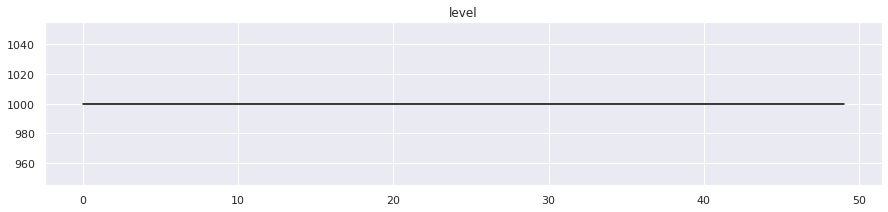

In [44]:
level = 1000*np.ones(50)

plt.plot(level, color='black')
plt.title('level')

Aggiungiamo la prima componente alla nostra serie temporale.

Text(0.5, 1.0, 'time series')

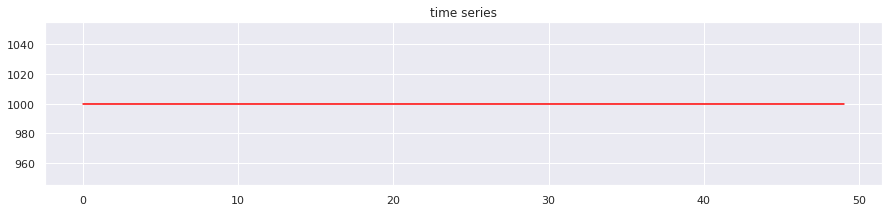

In [45]:
time_series = level

plt.plot(time_series, color='red')
plt.title('time series')

Passiamo alla componente di stagionalità. Utilizziamo la funzione *sin* di NumPy per generare un segnale periodico.

Text(0.5, 1.0, 'seasonality')

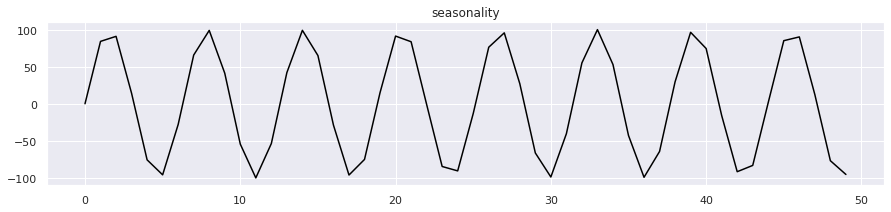

In [46]:
seasonality = 100*np.sin([i for i in range(50)])

plt.plot(seasonality, color='black')
plt.title('seasonality')

Aggiungiamo quindi la componente stagionale alla serie.

Text(0.5, 1.0, 'time series')

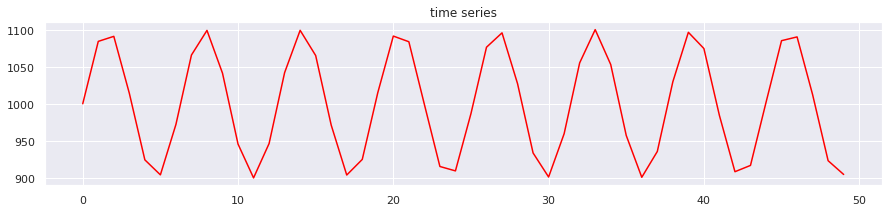

In [47]:
time_series = level + seasonality

plt.plot(time_series, color='red')
plt.title('time series')

Infine, aggiungiamo alla serie un trend lineare crescente.

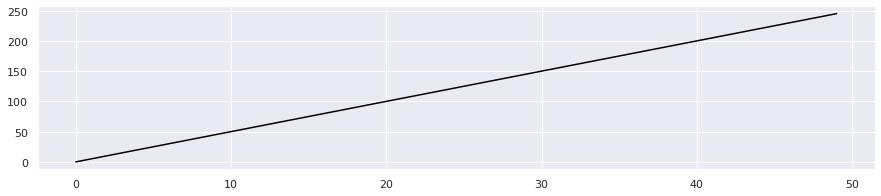

In [48]:
plt.plot(linear_trend, color='black')

Text(0.5, 1.0, 'time series')

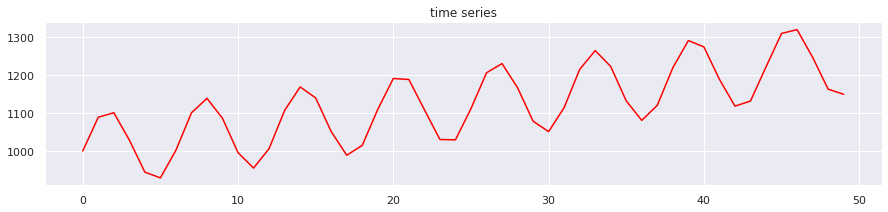

In [49]:
time_series = level + seasonality + linear_trend

plt.plot(time_series, color='red')
plt.title('time series')

Un altro tipo di modello di serie temporale è quello **moltiplicativo**, nel quale le componenti sono legate tra loro in modo non lineare.

In questo esempio, la componente di stagionalità viene moltiplicata con il (e quindi amplificata dal) trend crescente.

Text(0.5, 1.0, 'time series')

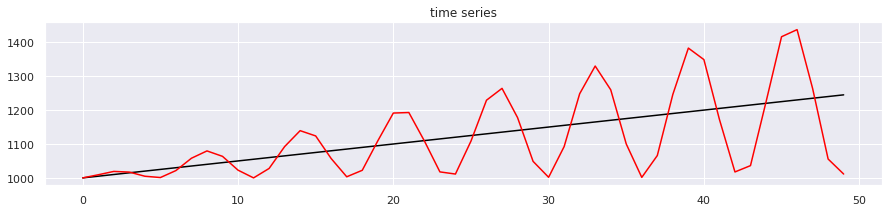

In [50]:
time_series = level + linear_trend + 0.01*linear_trend*seasonality

plt.plot(level+linear_trend, color='black')
plt.plot(time_series, color='red')
plt.title('time series')

*seasonal_decompose*
---

La funzione *seasonal_decompose* della libreria *statsmodel* permette di decomporre una serie nelle sue componenti costitutive.

**Nota**: si tratta di una decomposizione molto semplice: ne esistono di <a href="https://otexts.com/fpp2/decomposition.html">più raffinate</a>.

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [52]:
decomposition = seasonal_decompose(df['Consumption']['2015-01':'2015-06'])

L'oggetto restituito contiene una series Pandas per ognuna delle componenti.

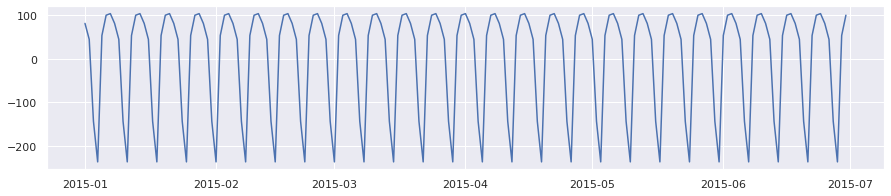

In [53]:
plt.figure(figsize=(15,3))
plt.plot(decomposition.seasonal)

È possibile visualizzare tutte le componenti in un'unica cella.

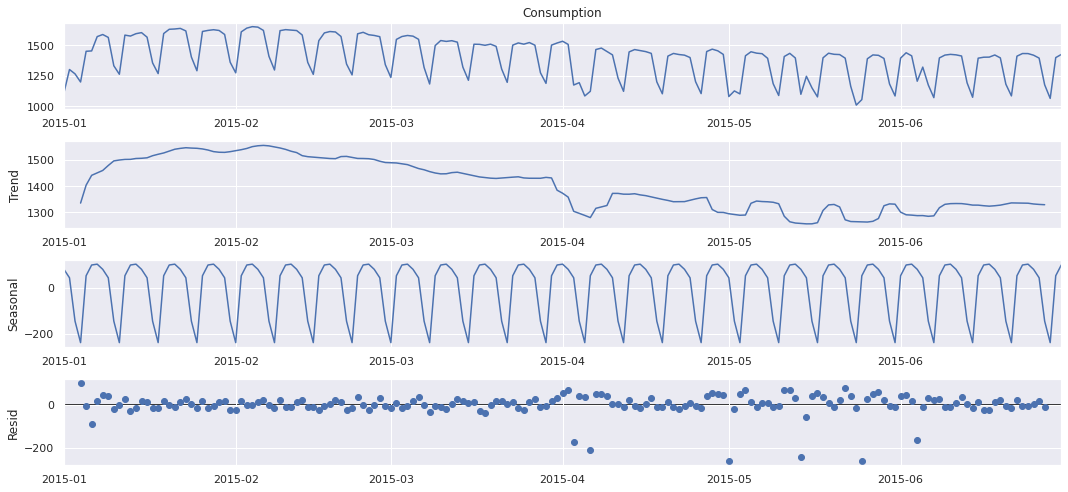

In [54]:
plt.rcParams['figure.figsize'] = (15,7)
plot = decomposition.plot()#evita plot doppi

**Recap**: una serie temporale additiva è la somma di componenti sistematiche (livello, trend, stagionalità) e di un termine residuo. In un modello moltiplicativo queste componenti sono legate tra loro in modo non lineare.

---

Forecast
===
L'analisi di una serie temporale è fondamentale per prevedere il suo comportamento futuro.

Il forecast dei valori di una serie temporale è un processo difficile che richiede competenze tecniche, scientifiche e di business. Esistono diversi modelli di previsione, ciascuno con la sua intuizione teorica e un numero di parametri da calibrare.

Facebook Prophet
---
Prophet è una procedura di forecast rilasciata nel 2017 da Facebook. Ecco alcune delle caratteristiche che la rendono uno strumento molto versatile:

- gestisce stagionalità multiple e bruschi cambiamenti di trend
- è resistente a dati mancanti e outlier
- è di facile utilizzo immediato e al tempo stesso altamente configurabile.

Importiamo la libreria (e silenziamo gli warning di Pandas).

In [55]:
import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet

Vogliamo predire i valori di consumo elettrico del 2017 a partire dai valori registrati nel passato.

In [56]:
df = pd.read_csv('../data/OPSD_Germany_consumption.csv',
                 parse_dates=True,
                 index_col='Date')

df.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


Separiamo i dati di apprendimento da quelli di test.

In [57]:
df_train = df['2006':'2016']
df_test = df['2017']

In [58]:
df_train

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131
...,...
2016-12-27,1289.324
2016-12-28,1294.881
2016-12-29,1295.897


In [59]:
df_test

,Consumption
Date,
2017-01-01,1130.41300
2017-01-02,1441.05200
2017-01-03,1529.99000
2017-01-04,1553.08300
2017-01-05,1547.23800
...,...
2017-12-27,1263.94091
2017-12-28,1299.86398
2017-12-29,1295.08753


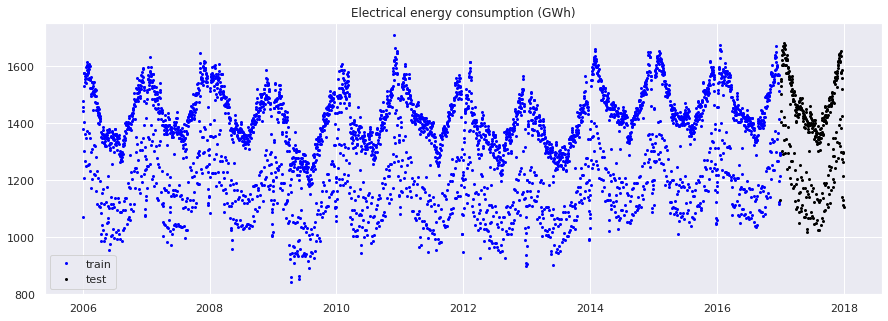

In [60]:
plt.figure(figsize=(15, 5))

plt.plot(df_train,
         marker='.',
         markersize=4,
         linestyle='',
         label='train',
         color='blue')

plt.plot(df_test,
         marker='.',
         markersize=4,
         linestyle='',
         label='test',
         color='black')

plt.title('Electrical energy consumption (GWh)')
plt.legend()

Prophet digerisce i dataframe Pandas, ma richiede una struttura particolare. Ci servono due colonne:
- *ds* per l'indice temporale
- *y*  per i valori numerici della serie.

Costruiamo il dataframe da passare a Prophet. Usiamo la funzione Pandas *reset_index* per trasformare l'indice temporale in una colonna.

In [61]:
df_train_prophet = df_train.reset_index()
df_train_prophet

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131
...,...,...
4013,2016-12-27,1289.324
4014,2016-12-28,1294.881
4015,2016-12-29,1295.897
4016,2016-12-30,1291.044


Rinominiamo le colonne come richiesto da Prophet.

In [62]:
df_train_prophet.columns = ['ds', 'y']
df_train_prophet

,ds,y
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131
...,...,...
4013,2016-12-27,1289.324
4014,2016-12-28,1294.881
4015,2016-12-29,1295.897
4016,2016-12-30,1291.044


Siamo pronti per l'addestramento. La sintassi è analoga a quella di Scikit-learn.

In [63]:
model = Prophet()
model.fit(df_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Costruiamo la struttura dati che conterrà le predizioni sul test set.

In [64]:
future = model.make_future_dataframe(periods=365, include_history=False)
future

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
360,2017-12-27
361,2017-12-28
362,2017-12-29
363,2017-12-30


Passiamo alla funzione *predict* del modello Prophet addestrato la struttura dati che abbiamo costruito.

In [65]:
test_predictions = model.predict(future)

La funzione predict restituisce un dataframe che contiene svariate colonne. La colonna *yhat* contiene le predizioni numeriche sul periodo di test.

In [66]:
test_predictions.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [67]:
test_predictions['yhat']

0      1070.342691
1      1366.486866
2      1415.421390
3      1431.827155
4      1432.430527
          ...     
360    1384.855671
361    1370.459421
362    1344.175997
363    1153.555920
364    1060.468883
Name: yhat, Length: 365, dtype: float64

Aggiungiamo la colonna con le predizioni numeriche al dataframe di test.

In [68]:
df_test['Prediction'] = test_predictions['yhat'].values
df_test

,Consumption,Prediction
Date,,
2017-01-01,1130.41300,1070.342691
2017-01-02,1441.05200,1366.486866
2017-01-03,1529.99000,1415.421390
2017-01-04,1553.08300,1431.827155
2017-01-05,1547.23800,1432.430527
...,...,...
2017-12-27,1263.94091,1384.855671
2017-12-28,1299.86398,1370.459421
2017-12-29,1295.08753,1344.175997


Confrontiamo graficamente i valori reali di consumo con quelli predetti dal modello di forecast.

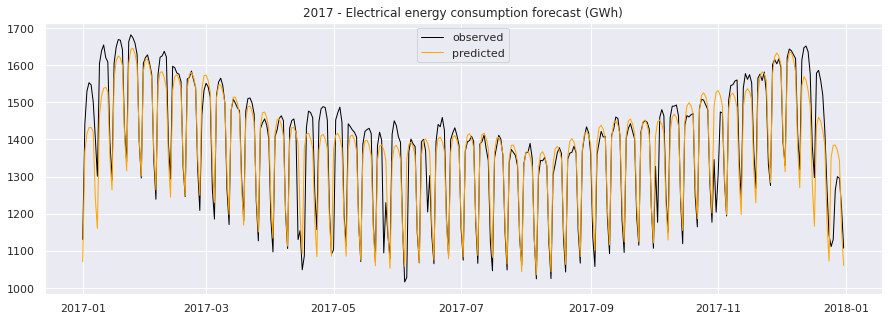

In [69]:
plt.figure(figsize=(15, 5))

plt.plot(df_test['Consumption'],
         linestyle='-',
         color='black',
         linewidth=1,
         label='observed')

plt.plot(df_test['Prediction'],
         linestyle='-',
         linewidth=1,
         color='orange',
         label='predicted')

plt.title('2017 - Electrical energy consumption forecast (GWh)')
plt.legend()

**Recap**: fin qui abbiamo
- separato training e test set
- costruito la struttura dati necessaria a Prophet per addestramento e predizione
- addestrato il modello sul training set
- ottenuto le predizioni sul test set
- confrontato le predizioni con i valori reali.

Siamo contenti? Come proseguiamo?

Come nell'apprendimento supervisionato, dobbiamo valutare *quantitativamente* i risultati della predizione. Ci serve cioè una **metrica** che quantifichi l'errore che commettiamo col nostro modello addestrato. <a href="https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/">Qui</a> trovate una discussione sulle metriche di valutazione adatte al forecast.

Un modello di apprendimento supervisionato prevede degli **iperparametri** da calibrare nella fase di **model selection**, attraverso i quali ottenere il giusto grado di fitting dei dati di apprendimento. In Scikit-learn, questi sono passati come argomento ai modelli: lo stesso vale per Prophet.

Tra gli argomenti della funzione *Prophet* troviamo ad esempio *changepoint_prior_scale*. Un <a href="https://facebook.github.io/prophet/docs/trend_changepoints.html">changepoint</a> è un instante temporale in cui la serie cambia bruscamente comportamento. Attraverso questo iperparametro è possibile impostare la sensibilità del modello ai changepoint:

<br>

<img src='../img/changepoints.png' width=400/>

<br>

Gli argomenti *daily_*, *weekly_* e *yearly_seasonality* permettono invece di decidere se includere queste stagionalità nel modello.

L'esempio grafico qui sopra è preso da <a href="https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a">questo articolo</a>, che è una risorsa interessante per approfondire il forecast con Prophet. <a href="https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274">Questo</a> è un altro articolo utile.

Esercizio 2.4
---

Ottenere e rappresentare il forecast della produzione di energia solare del 2017, utilizzando come training set gli anni dal 2012 al 2016.

---

Spunti di approfondimento
===

Le serie temporali sono un argomento ricco e complesso. Qui trovate alcune risorse utili per approfondire, divise per argomento.

**Strumenti Python**:
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html.

**Stazionarietà**:
- https://people.duke.edu/~rnau/411diff.htm
- https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/.

**Autocorrelazione**:
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- https://www.youtube.com/watch?v=ZjaBn93YPWo.

**Modelli di forecast**:

- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://www.youtube.com/watch?v=d4Sn6ny_5LI
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/.

**Forecast come apprendimento supervisionato**:
- https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/.

**Dataset**:
- https://www.kaggle.com/tags/time-series
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://machinelearningmastery.com/time-series-datasets-for-machine-learning/.

---

<script>
  $(document).ready(function(){
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('div.prompt').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by OVHCloud.
</footer>